In [1]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
from pathlib import Path
from sklearn import metrics

/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/data/hgh/anaconda3/envs/py310-torch25/lib/python3.10/site-packages/anndata/utils.py:429: 

In [3]:
data_root = Path('../data/BRCA1')

# sample name
sample_name = 'V1_Human_Breast_Cancer_Block_A_Section_1'
adata = sc.read_visium(data_root / sample_name)
print(adata)
adata.var_names_make_unique()

df_meta = pd.read_csv(data_root / 'metadata.tsv', sep='\t')
# 确保元数据中的索引与 adata.obs 中的索引匹配
df_meta.set_index('ID', inplace=True)
adata.obs.index = adata.obs.index.astype(str)
df_meta.index = df_meta.index.astype(str)
adata.obs['fine_annot_type'] = df_meta['fine_annot_type']
n_clusters = len(adata.obs['fine_annot_type'].unique())

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [4]:
x_pixel = adata.obsm['spatial'][:,0]
y_pixel = adata.obsm['spatial'][:,1]
adj = spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, histology=False)

Calculateing adj matrix using xy only...


In [5]:
adata.var_names_make_unique()
spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [6]:
p=0.5 
#Find the l value given p
l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)

Run 1: l [0.01, 1000], p [0.0, 83.64162436864945]
Run 2: l [0.01, 500.005], p [0.0, 21.58456802368164]
Run 3: l [0.01, 250.0075], p [0.0, 4.846828460693359]
Run 4: l [0.01, 125.00874999999999], p [0.0, 0.5336281061172485]
Run 5: l [62.509375, 125.00874999999999], p [0.00040018558502197266, 0.5336281061172485]
Run 6: l [93.7590625, 125.00874999999999], p [0.0820695161819458, 0.5336281061172485]
Run 7: l [109.38390625, 125.00874999999999], p [0.2545154094696045, 0.5336281061172485]
Run 8: l [117.196328125, 125.00874999999999], p [0.3819239139556885, 0.5336281061172485]
Run 9: l [121.1025390625, 125.00874999999999], p [0.4549444913864136, 0.5336281061172485]
recommended l =  123.05564453125


In [7]:
n_clusters = len(adata.obs['fine_annot_type'].unique())
#Set seed
r_seed=t_seed=n_seed=100
#Seaech for suitable resolution
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)

Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  12
Initializing cluster centers with louvain, resolution =  0.7999999999999999
Epoch  0
Epoch  10
Res =  0.7999999999999999 Num of clusters =  14
Res changed to 0.7999999999999999
Initializing cluster centers with louvain, resolution =  0.8999999999999999
Epoch  0
Epoch  10
Res =  0.8999999999999999 Num of clusters =  15
Res changed to 0.8999999999999999
Initializing cluster centers with louvain, resolution =  0.9999999999999999
Epoch  0
Epoch  10
Res =  0.9999999999999999 Num of clusters =  16
Res changed to 0.9999999999999999
Initializing cluster centers with louvain, resolution =  1.0999999999999999
Epoch  0
Epoch  10
Res =  1.0999999999999999 Num of clusters =  17
Res changed to 1.0999999999999999
Initializing cluster centers with louvain, resolution =  1.2
Epoch  0
Epoch  10
Res =  1.2 Num of clusters =  18
Res changed to 1.2
Initializing cl

In [8]:
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')

Initializing cluster centers with louvain, resolution =  1.3
Epoch  0
Epoch  10
Epoch  20
Epoch  30
delta_label  0.0034228541337546076 < tol  0.005
Reach tolerance threshold. Stopping training.
Total epoch: 37


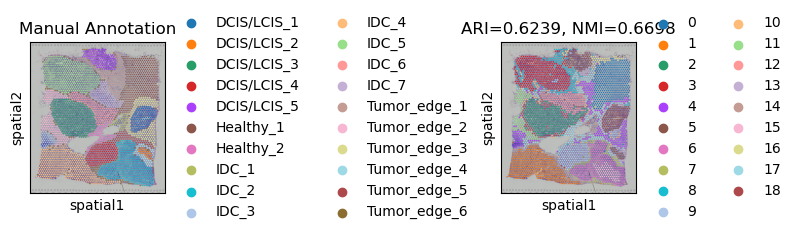

In [9]:
sub_adata = adata[~pd.isnull(adata.obs['fine_annot_type'])]
ARI = metrics.adjusted_rand_score(sub_adata.obs['fine_annot_type'], sub_adata.obs['pred'])
NMI = metrics.normalized_mutual_info_score(sub_adata.obs['fine_annot_type'], sub_adata.obs['pred'])
fig, axes = plt.subplots(1,2,figsize=(4*2, 4))
sc.pl.spatial(adata, color='fine_annot_type', ax=axes[0], show=False)
sc.pl.spatial(adata, color='pred', ax=axes[1], show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('ARI=%.4f, NMI=%.4f' % (ARI, NMI))
plt.tight_layout()
plt.show()